In [1]:
import datetime as dt

import polars as pl
import sf_quant.data as sfd
import matplotlib.pyplot as plt
import seaborn as sns

/home/msch2022/SATV/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-02-26 20:40:44,290	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
# Parameters
start = dt.date(2000, 1, 1)
end = dt.date(2024, 12, 31)
signal_name = "mom+satv"

gamma = 50

# Load MVO weights
weights = pl.read_parquet(f"weights/{signal_name}/{gamma}/*.parquet")

# Get returns
returns = (
    sfd.load_assets(
        start=start, end=end, columns=["date", "barrid", "return"], in_universe=True
    )
    .sort("date", "barrid")
    .select(
        "date",
        "barrid",
        pl.col("return").truediv(100).shift(-1).over("barrid").alias("forward_return"),
    )
)

In [3]:
# Compute portfolio returns
portfolio_returns = (
    weights.join(other=returns, on=["date", "barrid"], how="left")
    .group_by("date")
    .agg(pl.col("forward_return").mul(pl.col("weight")).sum().alias("return"))
    .sort("date")
)

shape: (1, 3)
┌─────────────┬────────────┬─────────┐
│ mean_return ┆ volatility ┆ sharpe  │
│ ---         ┆ ---        ┆ ---     │
│ f64         ┆ f64        ┆ f64     │
╞═════════════╪════════════╪═════════╡
│ 3.902359    ┆ 11.280128  ┆ 0.34595 │
└─────────────┴────────────┴─────────┘


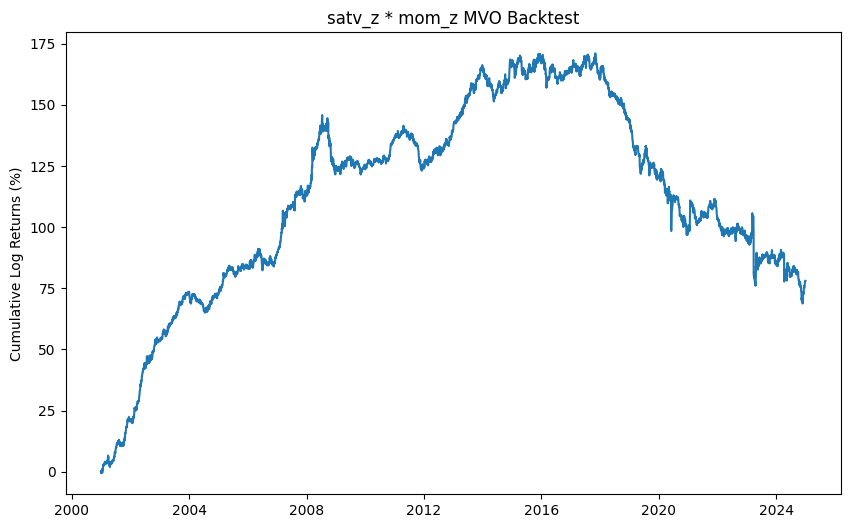

In [4]:
# Compute cumulative log returns
cumulative_returns = portfolio_returns.select(
    "date", pl.col("return").log1p().cum_sum().mul(100).alias("cumulative_return")
)

# Plot cumulative log returns
plt.figure(figsize=(10, 6))
sns.lineplot(cumulative_returns, x="date", y="cumulative_return")
plt.title("satv_z * mom_z MVO Backtest")
plt.xlabel("")
plt.ylabel("Cumulative Log Returns (%)")
plt.savefig("backtest_chart.png")

# Create summary table
summary = portfolio_returns.select(
    pl.col("return").mean().mul(252 * 100).alias("mean_return"),
    pl.col("return").std().mul(pl.lit(252).sqrt() * 100).alias("volatility"),
).with_columns(pl.col("mean_return").truediv(pl.col("volatility")).alias("sharpe"))

# Print summary
print(summary)